<img src="https://raw.githubusercontent.com/Sengsathit/OCR_data_scientist_assets/main/header_pret_a_depenser.png" alt="Alternative text" />

# Introduction

# Imports

In [11]:
import warnings
import pickle
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split

import xgboost as xgb

import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

import lightgbm as lgb
import gc

import matplotlib.pyplot as plt
import seaborn as sns

import shap

warnings.filterwarnings('ignore')

# Configurer Pandas pour un affichage complet du contenu des colonnes
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Chargement des données

In [13]:
# Données issues d'un feature engineering précédent
df = pd.read_csv('../../datasets/df_train_domain.csv')

# Retenir les noms des colonnes et les labels
colums = df.columns
labels = df['TARGET']

# Modélisation

### Fonctions réutilisables

In [3]:
def run_model_with_grid_search(
    model, 
    params_grid, 
    experiment_name, 
    model_name, 
    X_train, 
    y_train, 
    X_test, 
    y_test
):
    """
    Exécute GridSearchCV pour un modèle donné, enregistre les résultats et log les métriques et le modèle dans MLflow.
    
    Args:
        model: Le modèle à tester (ex : LogisticRegression, RandomForestClassifier, etc.).
        params_grid: Dictionnaire contenant les hyperparamètres pour GridSearch.
        experiment_name: Nom de l'expérience MLflow.
        model_name: Nom du modèle (pour l'enregistrement dans MLflow).
        X_train: Features d'entraînement.
        y_train: Labels d'entraînement.
        X_test: Features de test.
        y_test: Labels de test.

    Returns:
        estimator: Le meilleur estimateur trouvé par GridSearchCV.
    """
    # Configuration de GridSearchCV avec la métrique 'roc_auc'
    grid_search = GridSearchCV(
        model, 
        params_grid, 
        cv=5, 
        scoring='roc_auc', 
        return_train_score=True,
        n_jobs=-1
    )
    
    # Exécuter GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Afficher les résultats de GridSearch
    cv_results = grid_search.cv_results_
    for i in range(len(cv_results['params'])):
        print(f"Paramètres: {cv_results['params'][i]}")
        print(f"Score AUC moyen: {cv_results['mean_test_score'][i]}")
        print(f"Score AUC d'entraînement: {cv_results['mean_train_score'][i]}")
        print('-' * 50)
    
    # Extraire le meilleur modèle et les hyperparamètres
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Session MLflow
    mlflow.set_experiment(experiment_name)
    
    # Démarrer une nouvelle exécution
    with mlflow.start_run(run_name="Run"):
        # Loguer les hyperparamètres du meilleur modèle
        for param, value in best_params.items():
            mlflow.log_param(param, value)
        
        # Calculer et loguer l'AUC pour le train et le test
        y_pred_train_proba = best_model.predict_proba(X_train)[:, 1]
        y_pred_test_proba = best_model.predict_proba(X_test)[:, 1]
        auc_train = roc_auc_score(y_train, y_pred_train_proba)
        auc_test = roc_auc_score(y_test, y_pred_test_proba)
        
        mlflow.log_metric('auc_train', auc_train)
        mlflow.log_metric('auc_test', auc_test)
        
        # Loguer le modèle dans MLflow
        mlflow.sklearn.log_model(
            sk_model=best_model,
            artifact_path=f'{model_name}_best_model',
            signature=infer_signature(X_train, best_model.predict(X_train)),
            registered_model_name=f'{model_name}_best_model'
        )
    
    # Retourner le meilleur modèle
    return best_model

### MLflow

In [4]:
# Configuration du service MLflow, rediriger vers une instance locale
mlflow.set_tracking_uri(uri="http://13.38.185.52:8080")

### Pre-processing

In [5]:
# Supprimer la cible
df_transformed = df.drop(columns = ['SK_ID_CURR', 'TARGET'])

# Imputation médiane des valeurs manquantes
imputer = SimpleImputer(strategy = 'median')
imputer.fit(df_transformed)
data_transformed = imputer.transform(df_transformed)

# Normaliser chaque caractéristique entre 0 et 1
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(df_transformed)
data_transformed = scaler.transform(data_transformed)

# Sauvegarder l'imputer
with open('../tools/imputer.pkl', 'wb') as i:
    pickle.dump(imputer, i)

# Sauvegarder le scaler
with open('../tools/scaler.pkl', 'wb') as s:
    pickle.dump(scaler, s)

In [6]:
# Datasets d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(data_transformed, labels, test_size=0.2, random_state=42)

### Logistic Regression

In [7]:
logistic_regression = LogisticRegression(solver='liblinear')

params_logistic = {'C': [0.001, 0.01, 0.1, 1]}

run_model_with_grid_search(
    logistic_regression, 
    params_logistic, 
    "Logistic Regression", 
    "logistic_regression_classifier", 
    X_train, 
    y_train, 
    X_test, 
    y_test
)

Paramètres: {'C': 0.001}
Score AUC moyen: 0.7285654971544131
Score AUC d'entraînement: 0.7300105240310759
--------------------------------------------------
Paramètres: {'C': 0.01}
Score AUC moyen: 0.7416817519246457
Score AUC d'entraînement: 0.743935588693921
--------------------------------------------------
Paramètres: {'C': 0.1}
Score AUC moyen: 0.7444570996065287
Score AUC d'entraînement: 0.7476288033933193
--------------------------------------------------
Paramètres: {'C': 1}
Score AUC moyen: 0.7463279015672881
Score AUC d'entraînement: 0.7501107290752222
--------------------------------------------------


Registered model 'logistic_regression_classifier_best_model' already exists. Creating a new version of this model...
2024/09/08 15:17:39 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: logistic_regression_classifier_best_model, version 2
Created version '2' of model 'logistic_regression_classifier_best_model'.
2024/09/08 15:17:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run at: http://13.38.185.52:8080/#/experiments/155556389424329708/runs/0afef9ac544f428bb34c30417360c8f4.
2024/09/08 15:17:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://13.38.185.52:8080/#/experiments/155556389424329708.


LogisticRegression(C=1, solver='liblinear')

### Random Forest Classifier

In [8]:
random_forest_classifier = RandomForestClassifier()

params_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5]
}

run_model_with_grid_search(
    random_forest_classifier, 
    params_rf, 
    "Random Forest Classifier", 
    "random_forest_classifier", 
    X_train, 
    y_train, 
    X_test, 
    y_test
)

Paramètres: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}
Score AUC moyen: 0.7191083553839303
Score AUC d'entraînement: 0.7298096438676673
--------------------------------------------------
Paramètres: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
Score AUC moyen: 0.7204492601142387
Score AUC d'entraînement: 0.7319511394904626
--------------------------------------------------
Paramètres: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}
Score AUC moyen: 0.7204580669842626
Score AUC d'entraînement: 0.7322894181853814
--------------------------------------------------
Paramètres: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 50}
Score AUC moyen: 0.7171608682566157
Score AUC d'entraînement: 0.7283088144751051
--------------------------------------------------
Paramètres: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
Score AUC moyen: 0.7188162002492614
Score AUC d'entraînement: 0.7303854197784339
-----------------------

Registered model 'random_forest_classifier_best_model' already exists. Creating a new version of this model...
2024/09/08 15:23:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: random_forest_classifier_best_model, version 2
Created version '2' of model 'random_forest_classifier_best_model'.
2024/09/08 15:23:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run at: http://13.38.185.52:8080/#/experiments/721115244807505309/runs/a6f25aef3638459fbd28949390c3f5e0.
2024/09/08 15:23:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://13.38.185.52:8080/#/experiments/721115244807505309.


RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200)

### XGBoost Classifier

In [9]:
xgboost_classifier = xgb.XGBClassifier()

params_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

best_model = run_model_with_grid_search(
    xgboost_classifier, 
    params_xgb, 
    "XGBoost Classifier", 
    "xgboost_classifier",
    X_train, 
    y_train, 
    X_test, 
    y_test
)

Paramètres: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Score AUC moyen: 0.7053035814729915
Score AUC d'entraînement: 0.7073376206950306
--------------------------------------------------
Paramètres: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
Score AUC moyen: 0.703396162114429
Score AUC d'entraînement: 0.705940358666503
--------------------------------------------------
Paramètres: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Score AUC moyen: 0.7126580070491586
Score AUC d'entraînement: 0.7152389347520979
--------------------------------------------------
Paramètres: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Score AUC moyen: 0.7118445982082127
Score AUC d'entraînement: 0.7146975727271284
--------------------------------------------------
Paramètres: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Score AUC moyen: 0.72

Registered model 'xgboost_classifier_best_model' already exists. Creating a new version of this model...
2024/09/08 15:28:06 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: xgboost_classifier_best_model, version 2
Created version '2' of model 'xgboost_classifier_best_model'.
2024/09/08 15:28:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run Run at: http://13.38.185.52:8080/#/experiments/614187831548073206/runs/cbd7444cfa454e73b9f8db3af15a1424.
2024/09/08 15:28:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://13.38.185.52:8080/#/experiments/614187831548073206.


### Feature Importances : interprétation du meilleur modèle

 99%|===================| 60974/61503 [01:16<00:00]        

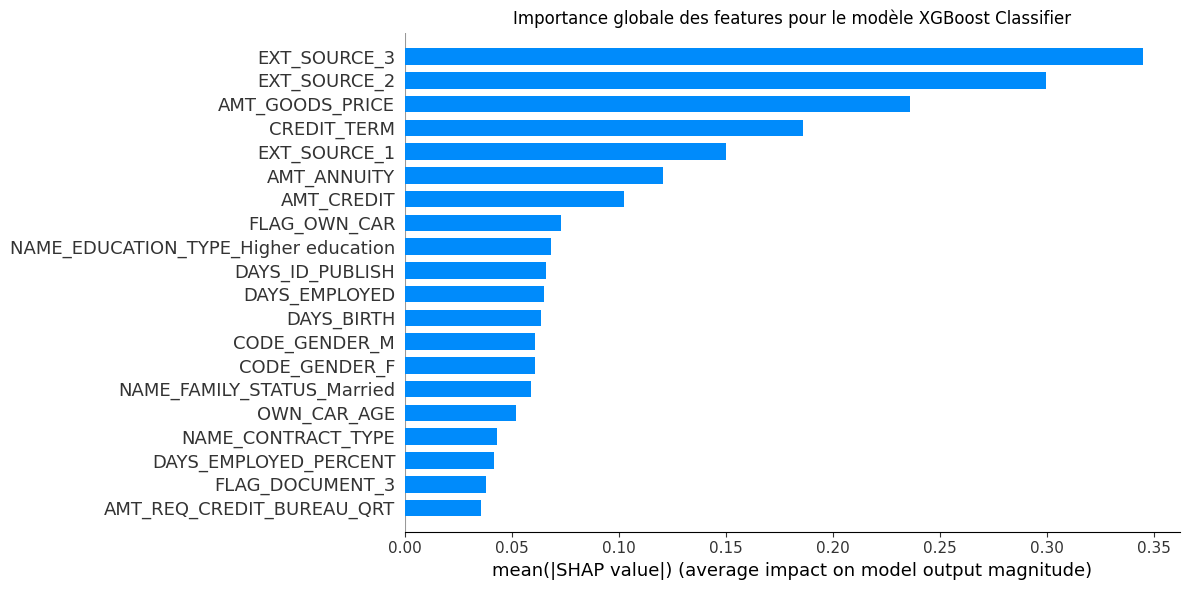

In [41]:
# Créer un explainer en fonction du modèle
explainer = shap.Explainer(best_model, X_train)

# Calculer les valeurs SHAP sur les données de test
shap_values = explainer(X_test)

# Créer un DataFrame pour associer les features à leurs valeurs SHAP
shap_df = pd.DataFrame(shap_values.values, columns=df_transformed.columns)

# Visualiser les feature importances
plt.title("Importance globale des features pour le modèle XGBoost Classifier")
shap.summary_plot(shap_values.values, features=shap_df, feature_names=df_transformed.columns, plot_type="bar", plot_size=[12,6])

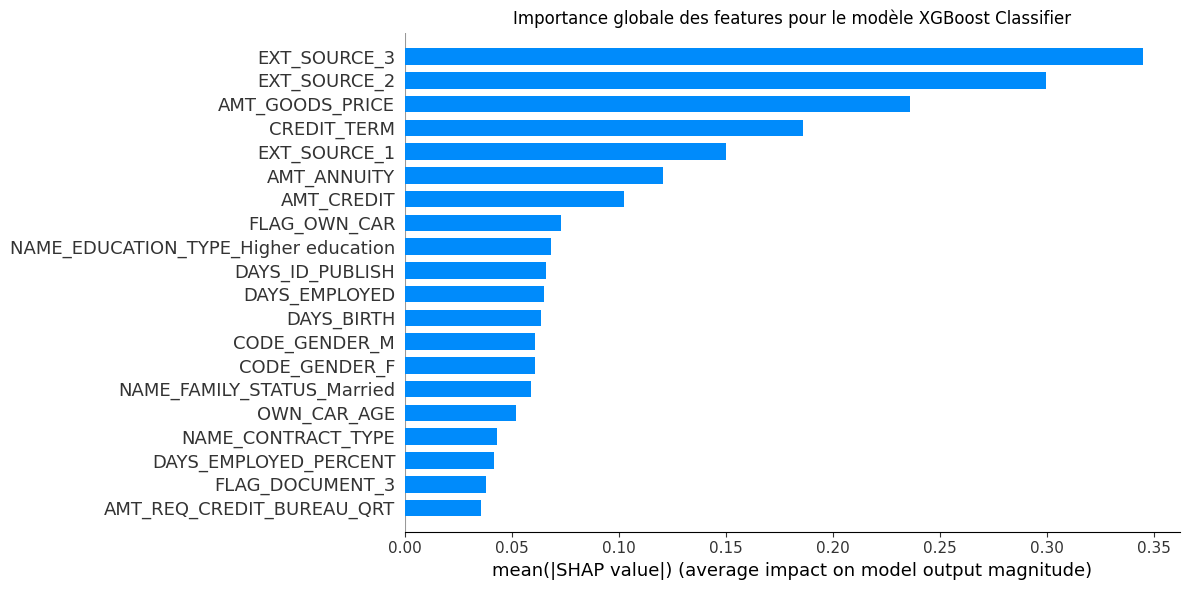